In [ ]:
# used for initializing the shapelets via KMeans
# NOTE: if you are just looking for a working solution of the learning shapelets algorithm you are advised to just use the implementation that is already provided by tslearn.
! pip install --user tslearn matplotlib

## Demo $\mathcal{L_R}$ loss

Demonstrates the use and effects of the regularized loss $\mathcal{L_R}$.

The data set used is the *UWaveGestureLibraryAll* dataset of the UCR archive:
> Yanping Chen, Eamonn Keogh, Bing Hu, Nurjahan Begum, Anthony Bagnall, Abdullah Mueen and Gustavo Batista (2015). The UCR Time Series Classification Archive. URL www.cs.ucr.edu/~eamonn/time_series_data/.

### NOTE I
The demo was performed on a GPU. You need to set `to_cuda=False` at the respective places in case you want to run on CPU. 

### NOTE II
To demonstrate the implementation, the shapelets to be learned are initialized via K-Means as was done in the original paper. To do so, we use the K-Means implementation of the library TSLearn. If you are just looking for a working implementation of LearningShapelets, you are advised to just use the TSLearn implementation. This repo just intends to provide an exemplary implementation using PyTorch.

In [1]:
import os
## TODO change to 0
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import sys
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.getcwd())

In [2]:
import random
import numpy
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
import torch
from torch import nn, optim

/home/baeumle/master-pytorch/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
from src.learning_shapelets import LearningShapelets

### Load and Normalze Data

Helper functions to normalize the data:

In [4]:
def normalize_standard(X, scaler=None):
    shape = X.shape
    data_flat = X.flatten()
    if scaler is None:
        scaler = StandardScaler()
        data_transformed = scaler.fit_transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    else:
        data_transformed = scaler.transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    return data_transformed, scaler

def normalize_data(X, scaler=None):
    if scaler is None:
        X, scaler = normalize_standard(X)
    else:
        X, scaler = normalize_standard(X, scaler)
    
    return X, scaler

Load and normalize training data:

In [5]:
dataset = "UWaveGestureLibraryAll"
# Load training data
X_train = numpy.load(open(os.path.join('data', f'{dataset}_train.npy'), 'rb'))
X_train_size = X_train.shape[0]
print(f"Shape X_train: {X_train.shape}")
# load trainng data labels
y_train = numpy.load(open(os.path.join('data', f'{dataset}_train_labels.npy'), 'rb'))
# normalize training data
X_train, scaler = normalize_data(X_train)

Shape X_train: (896, 1, 945)


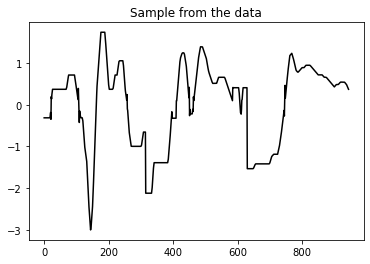

In [6]:
pyplot.title("Sample from the data")
pyplot.plot(X_train[0, 0], color='black')

### Learning Shapelets

Train a model using *Learning Shapelets* with cross-entropy loss as proposed in the orginial paper.

In [7]:
def sample_ts_segments(X, shapelets_size, n_segments=10000):
    """
    Sample time series segments for k-Means.
    """
    n_ts, n_channels, len_ts = X.shape
    samples_i = random.choices(range(n_ts), k=n_segments)
    segments = numpy.empty((n_segments, n_channels, shapelets_size))
    for i, k in enumerate(samples_i):
        s = random.randint(0, len_ts - shapelets_size)
        segments[i] = X[k, :, s:s+shapelets_size]
    return segments

In [8]:
def get_weights_via_kmeans(X, shapelets_size, num_shapelets, n_segments=10000):
    """
    Get weights via k-Means for a block of shapelets.
    """
    segments = sample_ts_segments(X, shapelets_size, n_segments).transpose(0, 2, 1)
    k_means = TimeSeriesKMeans(n_clusters=num_shapelets, metric="euclidean", max_iter=50).fit(segments)
    clusters = k_means.cluster_centers_.transpose(0, 2, 1)
    return clusters

Initialize parameters:

In [9]:
n_ts, n_channels, len_ts = X_train.shape
loss_func = nn.CrossEntropyLoss()
num_classes = len(set(y_train))
# learn 48 shapelets
shapelets_size_and_len = {189: 16, 378: 16, 567: 16}
dist_measure = "euclidean"
lr = 4e-3
wd = 1e-4
epsilon = 1e-7
batch_size = 256
shuffle = True
drop_last = False

Initialize shapelets via k-Means:

In [10]:
shapelets_blocks = []
for i, (shapelets_size, num_shapelets) in enumerate(shapelets_size_and_len.items()):
    weights_block = get_weights_via_kmeans(X_train, shapelets_size, num_shapelets)
    shapelets_blocks.append(weights_block)

Initialize *Learning Shapelets* model:

In [11]:
learning_shapelets = LearningShapelets(shapelets_size_and_len=shapelets_size_and_len,
                                       in_channels=n_channels,
                                       num_classes=num_classes,
                                       loss_func=loss_func,
                                       to_cuda=True,
                                       verbose=1,
                                       dist_measure=dist_measure)

Set weights:

In [12]:
for i, shapelets_block in enumerate(shapelets_blocks):
    learning_shapelets.set_shapelet_weights_of_block(i, shapelets_block)

Initialize optimizer for the *Learning Shapelets* model:

In [13]:
optimizer = optim.Adam(learning_shapelets.model.parameters(), lr=lr, weight_decay=wd, eps=epsilon)
learning_shapelets.set_optimizer(optimizer)

#### Train Learning Shapelets Model

In [14]:
def eval_accuracy(model, X, Y):
    predictions = model.predict(X)
    if len(predictions.shape) == 2:
        predictions = predictions.argmax(axis=1)
    print(f"Accuracy: {(predictions == Y).sum() / Y.size}")
    return (predictions == Y).sum() / Y.size

In [15]:
epochs = 200
n_epoch_steps = 5 * 8

In [16]:
losses = []
train_acc_last = 0
for _ in range(n_epoch_steps):
    losses += learning_shapelets.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    train_acc_current = eval_accuracy(learning_shapelets, X_train, y_train)
    if train_acc_current - train_acc_last < 1e-3 or train_acc_current == 1.0:
        break
    train_acc_last = train_acc_current

Loss: 0.10100051760673523:   0%|          | 1/200 [00:00<00:24,  8.14it/s]

Accuracy: 0.9877232142857143


Loss: 0.0572420209646225:   0%|          | 1/200 [00:00<00:24,  8.25it/s]

Accuracy: 0.9977678571428571


Loss: 0.04365639388561249: 100%|██████████| 200/200 [00:24<00:00,  8.29it/s] 


Accuracy: 1.0


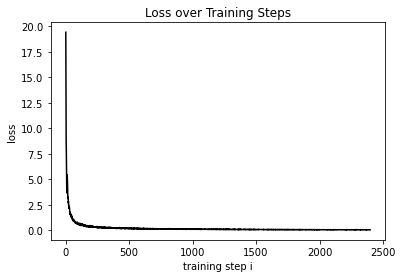

In [17]:
pyplot.plot(losses, color='black')
pyplot.title("Loss over Training Steps")
pyplot.xlabel("training step i")
pyplot.ylabel("loss")
pyplot.show()

#### Evaluate Accuracy of Learning Shapelets Model

Load test data:

In [18]:
# Load data set
X_test = numpy.load(open(os.path.join('data', f'{dataset}_test.npy'), 'rb'))
print(f"Shape X_train: {X_test.shape}")
y_test = numpy.load(open(os.path.join('data', f'{dataset}_test_labels.npy'), 'rb'))
# normalize data
X_train, scaler = normalize_data(X_train, scaler)

Shape X_train: (3582, 1, 945)


In [19]:
test_acc = eval_accuracy(learning_shapelets, X_test, y_test)

Accuracy: 0.9209938581797878


### Learning Shapelets with $\mathcal{L_R}$ loss

Train a model using *Learning Shapelets* with $\mathcal{L_R}$ loss as proposed here.

Initialize additional parameters:

In [20]:
l1 = 0.1
l2 = 0.01
k = int(0.1 * batch_size) if batch_size <= X_train_size else X_train_size

Initialize model:

In [21]:
learning_shapelets_Lr = LearningShapelets(shapelets_size_and_len=shapelets_size_and_len,
                                       in_channels=n_channels,
                                       num_classes=num_classes,
                                       loss_func=loss_func,
                                       to_cuda=True,
                                       verbose=1,
                                       dist_measure=dist_measure,
                                       l1=l1,
                                       l2=l2,
                                       k=k)

Set weights:

In [22]:
for i, shapelets_block in enumerate(shapelets_blocks):
    learning_shapelets_Lr.set_shapelet_weights_of_block(i, shapelets_block)

Initialize optimizer for the *Learning Shapelets* model:

In [23]:
optimizer = optim.Adam(learning_shapelets_Lr.model.parameters(), lr=lr, eps=epsilon)
learning_shapelets_Lr.set_optimizer(optimizer)

#### Train Model with $\mathcal{L_R}$

In [24]:
losses_acc = []
losses_dist = []
losses_sim = []
train_acc_last_Lr = 0
for _ in range(n_epoch_steps):
    losses_acc_i, losses_dist_i, losses_sim_i = \
        learning_shapelets_Lr.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                  shuffle=shuffle, drop_last=drop_last)
    losses_acc += losses_acc_i
    losses_dist += losses_dist_i
    losses_sim += losses_sim_i
    train_acc_current_Lr = eval_accuracy(learning_shapelets_Lr, X_train, y_train)
    if train_acc_current_Lr - train_acc_last_Lr < 1e-3 or train_acc_current_Lr == 1.0:
        break
    train_acc_last_Lr = train_acc_current_Lr

Loss CE: 0.09190087765455246, Loss dist: 0.8721584677696228, Loss sim: 0.00025745658786036074: 100%|██████████| 200/200 [00:46<00:00,  4.30it/s]
  0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.9854910714285714


Loss CE: 0.027099845930933952, Loss dist: 0.8176196217536926, Loss sim: 0.0003574558941181749: 100%|██████████| 200/200 [00:46<00:00,  4.29it/s] 
  0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.9988839285714286


Loss CE: 0.025103308260440826, Loss dist: 0.82084721326828, Loss sim: 0.0004358950536698103: 100%|██████████| 200/200 [00:46<00:00,  4.30it/s]   

Accuracy: 0.9988839285714286


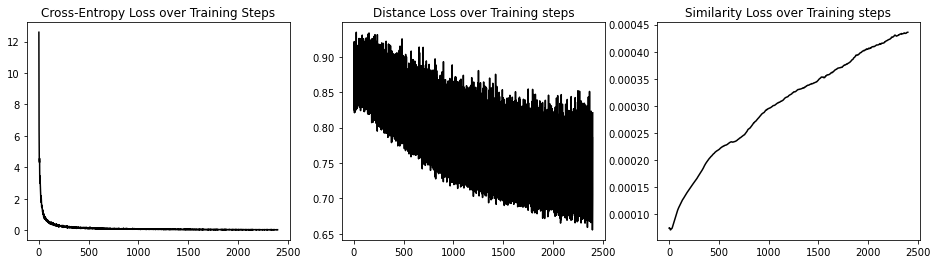

In [25]:
fig, axes = pyplot.subplots(1, 3)
fig.set_size_inches(16, 4)

axes[0].plot(losses_acc, color='black')
axes[0].title.set_text("Cross-Entropy Loss over Training Steps")

axes[1].plot(losses_dist, color='black')
axes[1].title.set_text("Distance Loss over Training steps")

axes[2].plot(losses_sim, color='black')
axes[2].title.set_text("Similarity Loss over Training steps")

pyplot.show()

### Evaluate Accuracy of Learning Shapelets Model with $\mathcal{L_R}$

In [26]:
test_acc_Lr = eval_accuracy(learning_shapelets_Lr, X_test, y_test)

Accuracy: 0.9371859296482412


## Compare the Shapelets of the two Models

Define some helper functions:

In [27]:
def filterNanFromShapelet(shapelet):
    """
    Filter NaN values from a shapelet.
    Needed for the output of learning shapelets from tslearn, since smaller size shapelets are padded with NaN values.
    Note: Make sure the NaN values are only leading or trailing.
    """
    return shapelet[~numpy.isnan(shapelet)]

def lead_pad_shapelet(shapelet, pos):
    """
    Adding leading NaN values to shapelet to plot it on a time series at the best matching position.
    """
    pad = numpy.empty(pos)
    pad[:] = numpy.NaN
    padded_shapelet = numpy.concatenate([pad, filterNanFromShapelet(shapelet)])
    return padded_shapelet

def torch_dist_ts_shapelet(ts, shapelet, to_cuda=True):
    """
    Use PyTorch to calculate the distance between a shapelet and a time series.
    Implemented via unfolding.
    """
    if not isinstance(ts, torch.Tensor):
        ts = torch.tensor(ts, dtype=torch.float)
    if not isinstance(shapelet, torch.Tensor):
        shapelet = torch.tensor(shapelet, dtype=torch.float)
    if to_cuda:
        ts = ts.cuda()
        shapelet = shapelet.cuda()
    if shapelet.dim() == 1:
        shapelet = torch.unsqueeze(shapelet, 0)
    # unfold time series to emulate sliding window
    ts = ts.unfold(1, shapelet.shape[1], 1)
    # calculate euclidean distance over each segment
    dists = torch.sum(torch.cdist(ts, shapelet, p=2), dim=0)
    # filter min dist
    d_min, d_argmin = torch.min(dists, 0)
    return (d_min.item(), d_argmin.item())

def dists_to_shapelet(data, shapelet, to_cuda=True):
    """
    Calculate the distances of a shapelet to a bunch of time series.
    """
    shapelet = filterNanFromShapelet(shapelet)
    dists = []
    for i in range(len(data)):
        dists.append((torch_dist_ts_shapelet(data[i,:], shapelet, to_cuda=to_cuda), i))
    return sorted(dists, key=lambda x: x[0][0])

def plot_shapelet_on_ts_at_i(shapelet, ts, i, title="", axis=None):
    """
    Plot a shapelet on top of a timeseries
    """
    shapelet = filterNanFromShapelet(shapelet)
    padded_shapelet = lead_pad_shapelet(shapelet, i)
    if axis is None:
        pyplot.clf()
        pyplot.rcParams["figure.figsize"] = (23, 6)
        pyplot.plot(ts)
        pyplot.plot(padded_shapelet)
    else:
        axis.plot(ts)
        axis.plot(padded_shapelet)

In [28]:
shapelets_ce = learning_shapelets.get_shapelets()
shapelets_Lr = learning_shapelets_Lr.get_shapelets()
n_shapelets_ce = shapelets_ce.shape[0]
n_shapelets_Lr = shapelets_Lr.shape[0]
n_shapelets = max(n_shapelets_ce, n_shapelets_Lr)

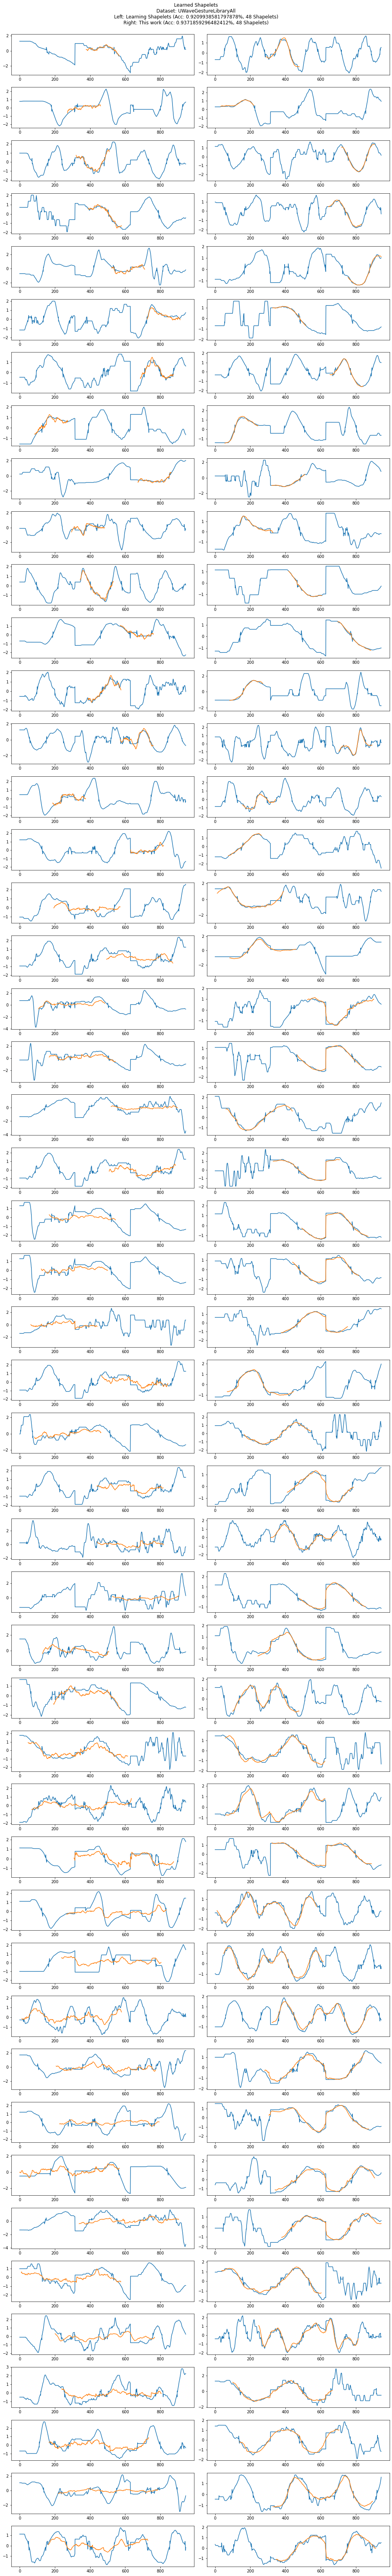

In [29]:
fig, axes = pyplot.subplots(n_shapelets, 2)
pyplot.rcParams['axes.facecolor'] = 'white'
pyplot.rcParams['savefig.facecolor']='white'
fig.suptitle(f'Learned Shapelets\nDataset: {dataset}\nLeft: Learning Shapelets (Acc: {test_acc}%, {n_shapelets_ce} Shapelets)\nRight: This work (Acc: {test_acc_Lr}%, {n_shapelets_Lr} Shapelets)')
fig.set_size_inches(14, 2 * n_shapelets)

relative_distances_gra = []
relative_distances_contrastive = []
for i in range(n_shapelets):
    if i < n_shapelets_ce:
        shapelet_ce = filterNanFromShapelet(shapelets_ce[i, 0])
        best_match_ce = dists_to_shapelet(X_test, shapelet_ce, to_cuda=True)[0]
        plot_shapelet_on_ts_at_i(shapelet_ce, X_test[best_match_ce[1], 0], best_match_ce[0][1], axis=axes[i, 0])
    if i < n_shapelets_Lr:
        shapelet_Lr = filterNanFromShapelet(shapelets_Lr[i, 0])
        best_match_Lr = dists_to_shapelet(X_test, shapelet_Lr, to_cuda=True)[0]
        plot_shapelet_on_ts_at_i(shapelet_Lr, X_test[best_match_Lr[1], 0], best_match_Lr[0][1], axis=axes[i, 1])
pyplot.tight_layout(rect=[0, 0.03, 1, 0.98])
pyplot.show()